# **Install Packages**

In [3]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure, color

# **Read Image**

array([[223, 218, 211, ..., 103, 170, 255],
       [223, 234, 220, ..., 103, 170, 255],
       [223, 223, 213, ..., 103, 170, 255],
       ...,
       [172, 182, 182, ...,   0,  95, 255],
       [172, 181, 177, ...,   0,  98, 255],
       [172, 193, 173, ...,   1,  97, 255]], dtype=uint8)
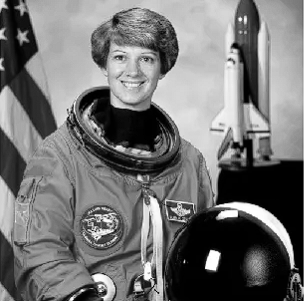

In [4]:
img = cv2.imread("/content/Hog algo image.png")
img_GRY = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_GRY

In [5]:
hog_features, hog_image = hog(
    img_GRY,
    orientations=9,
    pixels_per_cell=(8,8),
    cells_per_block=(2,2),
    block_norm='L2-Hys',
    visualize=True,
)

# **HOG from Scratch**

### 1. Preprocessing

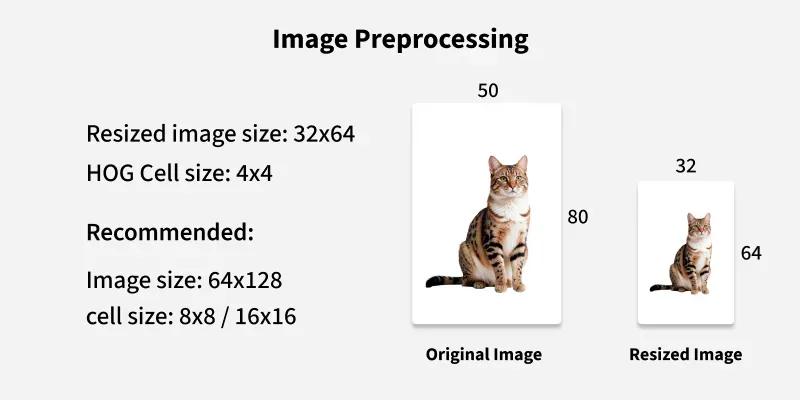

In [6]:
def preprocessing(img):
  img_GRY = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_blur = cv2.GaussianBlur(img_GRY, (5,5), 0)
  prepro_img = cv2.resize(img_blur,(32,64))
  return prepro_img

### 2. Compute Gradients

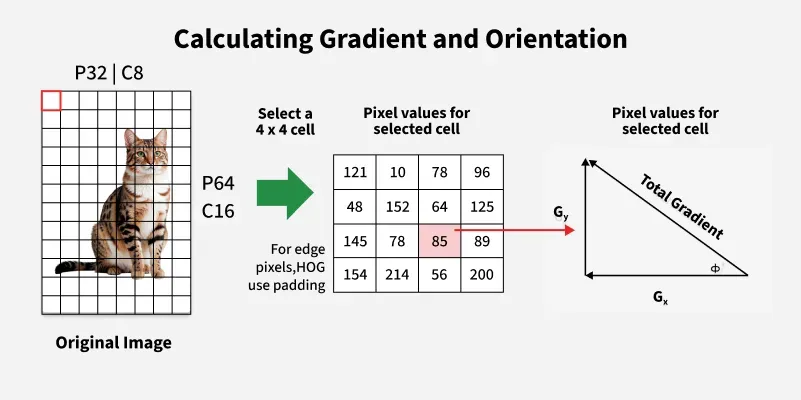

In [7]:
def calc_gradients(prepro_img):
  sobel_x = cv2.Sobel(prepro_img, cv2.CV_64F, 1,0, ksize=5)
  sobel_y = cv2.Sobel(prepro_img, cv2.CV_64F, 0,1, ksize=5)
  return sobel_x, sobel_y

### 3. Create Orientation Histograms

In [8]:
def convertToHistogram(prepro_img):
  grad_x, grad_y = calc_gradients(prepro_img)
  mag, angle = cv2.cartToPolar(grad_x, grad_y)
  return mag, angle

### 4. Normalisation

### 5. 9 pin histogram

In [9]:
def converto9pinhistogramdependonangle(mag, angle, cell_size=(8, 8)):
  img_height, img_width = mag.shape
  cell_height, cell_width = cell_size
  num_cells_y = img_height // cell_height
  num_cells_x = img_width // cell_width
  cell_histograms = np.zeros((num_cells_y, num_cells_x, 9))

  for i in range(num_cells_y):
    for j in range(num_cells_x):
      cell_mag = mag[i * cell_height:(i + 1) * cell_height, j * cell_width:(j + 1) * cell_width]
      cell_angle = angle[i * cell_height:(i + 1) * cell_height, j * cell_width:(j + 1) * cell_width]
      hist = np.zeros(9)
      for row in range(cell_height):
        for col in range(cell_width):
          pixel_angle = cell_angle[row][col]
          pixel_mag = cell_mag[row][col]

          if pixel_angle >= 0 and pixel_angle < 20:
            hist[0] += pixel_mag
          elif pixel_angle >= 20 and pixel_angle < 40:
            dist_to_20 = pixel_angle - 20
            dist_to_40 = 40 - pixel_angle
            total_dist = dist_to_20 + dist_to_40
            hist[0] += (dist_to_40 / total_dist) * pixel_mag
            hist[1] += (dist_to_20 / total_dist) * pixel_mag
          elif pixel_angle >= 40 and pixel_angle < 60:
            dist_to_40 = pixel_angle - 40
            dist_to_60 = 60 - pixel_angle
            total_dist = dist_to_40 + dist_to_60
            hist[1] += (dist_to_60 / total_dist) * pixel_mag
            hist[2] += (dist_to_40 / total_dist) * pixel_mag
          elif pixel_angle >= 60 and pixel_angle < 80:
            dist_to_60 = pixel_angle - 60
            dist_to_80 = 80 - pixel_angle
            total_dist = dist_to_60 + dist_to_80
            hist[2] += (dist_to_80 / total_dist) * pixel_mag
            hist[3]+= (dist_to_60 / total_dist) * pixel_mag
          elif pixel_angle >= 80 and pixel_angle < 100:
            dist_to_80 = pixel_angle - 80
            dist_to_100 = 100 - pixel_angle
            total_dist = dist_to_80 + dist_to_100
            hist[3] += (dist_to_100 / total_dist) * pixel_mag
            hist[4] += (dist_to_80 / total_dist) * pixel_mag
          elif pixel_angle >= 100 and pixel_angle < 120:
            dist_to_100 = pixel_angle - 100
            dist_to_120 = 120 - pixel_angle
            total_dist = dist_to_100 + dist_to_120
            hist[4] += (dist_to_120 / total_dist) * pixel_mag
            hist[5] += (dist_to_100 / total_dist) * pixel_mag
          elif pixel_angle >= 120 and pixel_angle < 140:
            dist_to_120 = pixel_angle - 120
            dist_to_140 = 140 - pixel_angle
            total_dist = dist_to_120 + dist_to_140
            hist[5] += (dist_to_140 / total_dist) * pixel_mag
            hist[6] += (dist_to_120 / total_dist) * pixel_mag
          elif pixel_angle >= 140 and pixel_angle < 160:
            dist_to_140 = pixel_angle - 140
            dist_to_160 = 160 - pixel_angle
            total_dist = dist_to_140 + dist_to_160
            hist[6] += (dist_to_160 / total_dist) * pixel_mag
            hist[7] += (dist_to_140 / total_dist) * pixel_mag
          elif pixel_angle >= 160 and pixel_angle < 180:
            dist_to_160 = pixel_angle - 160
            dist_to_180 = 180 - pixel_angle
            total_dist = dist_to_160 + dist_to_180
            hist[7] += (dist_to_180 / total_dist) * pixel_mag
            hist[8] += (dist_to_160 / total_dist) * pixel_mag
      cell_histograms[i, j, :] = hist
  return cell_histograms

### 6. Normalize Blocks

In [10]:
def normalize_blocks(cell_histograms, block_size=(2, 2)):
  num_cells_y, num_cells_x, num_bins = cell_histograms.shape
  block_height, block_width = block_size
  normalized_blocks = []

  for i in range(0, num_cells_y - block_height + 1, block_height):
    for j in range(0, num_cells_x - block_width + 1, block_width):
      block_hist = cell_histograms[i:i + block_height, j:j + block_width, :].flatten()
      norm = np.linalg.norm(block_hist)
      if norm > 0:
        block_hist = block_hist / norm
      normalized_blocks.append(block_hist)

  return np.array(normalized_blocks)

In [11]:
def create_hog_feature_vector(normalized_blocks):
  hog_feature_vector = np.concatenate(normalized_blocks)
  return hog_feature_vector

### function to visualize HOG features on the original image


In [12]:
def visualize_hog_on_image(img, cell_histograms, cell_size=(8, 8)):
    vis_img = np.zeros_like(img, dtype=np.uint8)
    num_cells_y, num_cells_x, _ = cell_histograms.shape
    cell_height, cell_width = cell_size
    for i in range(num_cells_y):
        for j in range(num_cells_x):
            hist = cell_histograms[i, j, :]
            max_bin = np.argmax(hist)
            angle = max_bin * 20
            magnitude = hist[max_bin]
            line_length = int(magnitude / np.max(cell_histograms) * 10)
            center_x = j * cell_width + cell_width // 2
            center_y = i * cell_height + cell_height // 2
            angle_rad = np.deg2rad(angle)
            end_x = int(center_x + line_length * np.cos(angle_rad))
            end_y = int(center_y - line_length * np.sin(angle_rad))
            cv2.line(vis_img, (center_x, center_y), (end_x, end_y), 255,1)
    return vis_img

In [13]:
# Compute HOG features from scratch
mag, angle = convertToHistogram(img_GRY)
cell_histograms = converto9pinhistogramdependonangle(mag, angle)
normalized_blocks = normalize_blocks(cell_histograms)
hog_feature_vector = create_hog_feature_vector(normalized_blocks)

print("Scratch HOG feature vector shape:", hog_feature_vector.shape)

Scratch HOG feature vector shape: (12312,)


In [14]:
# HOG with skimage
from skimage.feature import hog
from skimage import color, data
import matplotlib.pyplot as plt
imagesk = cv2.imread(cv2.samples.findFile("/content/Hog algo image.png"))
gray = cv2.cvtColor(imagesk, cv2.COLOR_BGR2GRAY)
hog_features, hog_image = hog(gray,orientations=9,pixels_per_cell=(8, 8),cells_per_block=(2, 2),block_norm='L2-Hys',visualize=True)


# **Compare between HOG Methods**

# **HOG from Skimage**

(np.float64(-0.5), np.float64(304.5), np.float64(300.5), np.float64(-0.5))

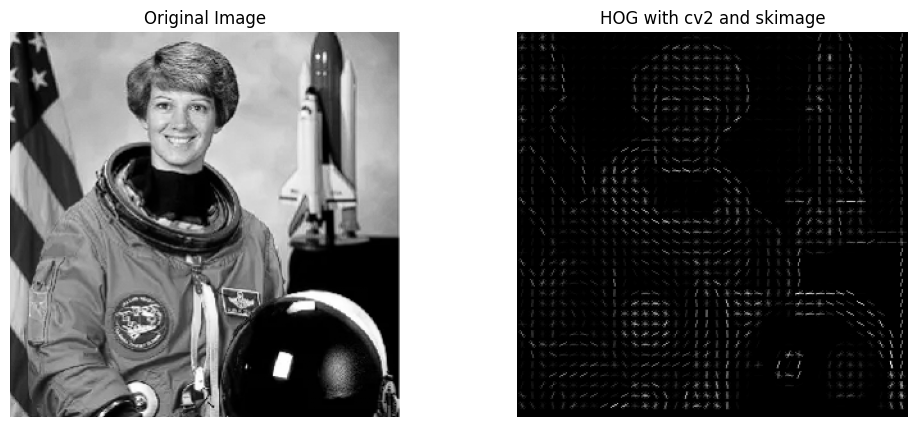

In [15]:
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(12,5))
ax1.imshow(img_GRY, cmap='gray')
ax1.set_title('Original Image')
ax1.axis('off')
ax2.imshow(hog_image, cmap='gray')
ax2.set_title('HOG with cv2 and skimage')
ax2.axis('off')

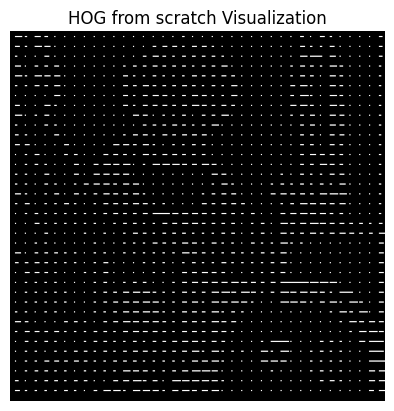

HOG Feature Vector Length (skimage): 47952


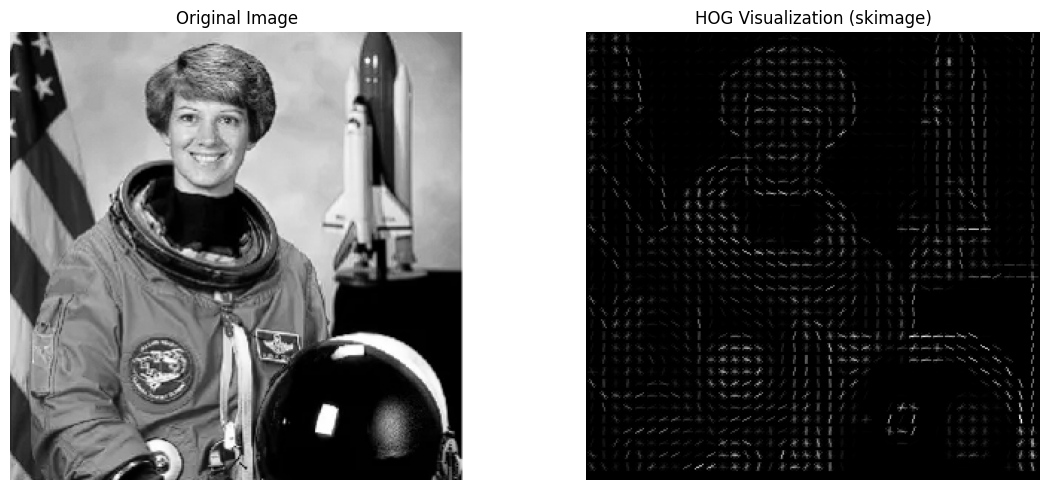

In [16]:
hog_vis_img = visualize_hog_on_image(img_GRY, cell_histograms)
plt.imshow(hog_vis_img, cmap='gray')
plt.title('HOG from scratch Visualization')
plt.axis('off')
plt.show()

print("HOG Feature Vector Length (skimage):", len(hog_features))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(gray, cmap='gray')
ax1.set_title('Original Image')
ax1.axis('off')
ax2.imshow(hog_image, cmap='gray')
ax2.set_title('HOG Visualization (skimage)')
ax2.axis('off')
plt.tight_layout()
plt.show()